In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import collections

from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    confusion_matrix,
    classification_report
)

from tensorflow.python.platform import build_info as tf_build_info
from collections import Counter
print(tf_build_info.build_info)

OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


In [30]:
data = pd.read_csv("C:/models/data/truss_rebalanced.csv", quotechar='"')

In [31]:
X = data.drop(["material_cost_per_truss", "build_cost_per_truss", "setup_cost_per_run"], axis=1)
y = data[["setup_cost_per_run"]]
X = X.astype(float)
y = y.astype(float)

In [32]:
# ==================================================
# SETUP COST DATA PREPARATION FUNCTION
# ==================================================
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import numpy as np
import pandas as pd


def prepare_setup_cost_data(X, y, target_col="setup_cost_per_run", min_class_samples=100, random_state=42):
    """
    Prepares the Setup Cost classification dataset:
      - Encodes target labels
      - Merges rare classes with nearest neighbors
      - Performs stratified train/test split
      - Scales features
      - Computes class weights

    Returns:
        dict with keys:
            X_train_scaled, X_test_scaled,
            y_train_lbl, y_test_lbl,
            num_classes, setup_cost_levels,
            class_weights, label_encoder
    """

    # --- 1. Prepare target and encode labels ---
    y_setup = y[[target_col]].copy()
    enc_setup = LabelEncoder()
    y_setup_labels = enc_setup.fit_transform(y_setup.values.ravel())

    # --- Merge rare classes with nearest neighbor ---
    counts = Counter(y_setup_labels)
    class_info = pd.DataFrame({
        "class_id": np.arange(len(enc_setup.classes_)),
        "setup_cost": enc_setup.classes_.astype(float),
        "count": [counts.get(i, 0) for i in range(len(enc_setup.classes_))]
    })

    y_setup_merged = y_setup_labels.copy()
    class_info_sorted = class_info.sort_values("setup_cost").reset_index(drop=True)

    for _, row in class_info_sorted.iterrows():
        cls = row["class_id"]
        count = row["count"]
        if count < min_class_samples:
            cost = row["setup_cost"]

            # Find valid (non-rare) classes
            valid_classes = class_info_sorted[class_info_sorted["count"] >= min_class_samples]
            if valid_classes.empty:
                continue

            # Find nearest valid class by setup cost
            nearest_idx = (valid_classes["setup_cost"] - cost).abs().idxmin()
            nearest_class = valid_classes.loc[nearest_idx, "class_id"]
            nearest_cost = valid_classes.loc[nearest_idx, "setup_cost"]

            y_setup_merged[y_setup_merged == cls] = nearest_class
            print(f"Class {int(cls):2d} (${cost:.2f}, {count} samples) → merged into "
                  f"Class {int(nearest_class):2d} (${nearest_cost:.2f})")

    # --- Show final class distribution ---
    new_counts = Counter(y_setup_merged)
    df_counts_setup = pd.DataFrame({
        "Class_ID": list(new_counts.keys()),
        "Setup_Cost_$": [float(enc_setup.classes_[int(cls)]) for cls in new_counts.keys()],
        "Samples": list(new_counts.values())
    }).sort_values("Setup_Cost_$").reset_index(drop=True)

    pd.set_option("display.max_rows", None)
    print("\nFinal Setup Cost Class Distribution:")
    print(df_counts_setup)

    # --- 2. Split (stratified) ---
    x_train, x_test, y_train_lbl, y_test_lbl = train_test_split(
        X, y_setup_merged,
        test_size=0.2,
        random_state=random_state,
        stratify=y_setup_merged
    )

    # --- 3. Scale features ---
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # --- 4. Compute class weights ---
    num_classes = len(enc_setup.classes_)
    all_classes = np.arange(num_classes)
    present_classes = np.unique(y_train_lbl)

    weights_arr = compute_class_weight(
        class_weight='balanced',
        classes=present_classes,
        y=y_train_lbl
    )
    present_weights = dict(zip(present_classes, weights_arr))

    class_weights = {
        int(cls): float(present_weights.get(cls, 1.0))
        for cls in all_classes
    }

    setup_cost_levels = enc_setup.classes_.astype(float)

    return {
        "X_train_scaled": x_train_scaled,
    "X_test_scaled": x_test_scaled,
    "y_train_lbl": y_train_lbl,
    "y_test_lbl": y_test_lbl,
    "num_classes": num_classes,
    "setup_cost_levels": setup_cost_levels,
    "class_weights": class_weights,
    "label_encoder": enc_setup,
    "scaler": scaler  
    }


In [33]:
from tensorflow.keras import models, layers, regularizers, optimizers, callbacks
import tensorflow as tf


# ===============================
# MODEL BUILDER
# ===============================
def build_setup_cost_classifier(input_dim, num_classes, l2_reg=1e-4, learning_rate=1e-3):
    """Builds and compiles the Setup Cost classification model."""
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=[input_dim]),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')
        ]
    )
    return model

In [34]:
# ===============================
# TRAINING FUNCTION
# ===============================
def train_setup_cost_classifier(model, x_train, y_train, batch_size=256, epochs=100):
    """Trains the Setup Cost classification model with early stopping and LR reduction."""
    print("Training Setup Cost CLASSIFIER...")

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5
    )
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    with tf.device('/GPU:0'):
        history = model.fit(
            x_train, y_train,
            validation_split=0.2,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=[reduce_lr, early_stop],
        )

    return history

In [35]:
# ==================================================
# SETUP COST CLASSIFIER EVALUATION FUNCTION
# ==================================================
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime


def evaluate_setup_cost_classifier(
    model,
    history,
    x_test_scaled,
    y_test_lbl,
    y_train_lbl,
    setup_cost_levels,
    output_prefix="setup_cost_evaluation"
):
    """
    Evaluates the Setup Cost classifier, visualizes results, and generates a detailed report file.

    Args:
        model: Trained Keras model.
        history: Training history object from model.fit().
        x_test_scaled: Scaled test feature matrix.
        y_test_lbl: True labels for test data.
        y_train_lbl: True labels for training data (for class distribution plot).
        setup_cost_levels: Array of dollar values corresponding to encoded class IDs.
        output_prefix: Base name for the saved evaluation report.

    Returns:
        report_path: Path to the saved report file.
        metrics: Dict with accuracy, MAE, RMSE, and max_error.
    """

    # --- Make predictions ---
    probs_test = model.predict(x_test_scaled)
    pred_lbl = probs_test.argmax(axis=1)
    pred_argmax = setup_cost_levels[pred_lbl]

    # Expected value predictions (for smoother continuous estimate)
    pred_ev = probs_test @ setup_cost_levels
    y_true = setup_cost_levels[y_test_lbl]

    # ==================================================
    # VISUALIZE TRAINING HISTORY
    # ==================================================
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Setup Cost Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Actual vs Predicted (Argmax) ---
    plt.figure(figsize=(7, 6))
    plt.scatter(y_true, pred_argmax, alpha=0.7, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r--', lw=2)
    plt.title("Actual vs Predicted Setup Cost per Run (Argmax Prediction)")
    plt.xlabel("Actual Setup Cost ($)")
    plt.ylabel("Predicted Setup Cost ($)")
    plt.grid(True)
    plt.show()

    # --- Actual vs Predicted (Expected Value) ---
    plt.figure(figsize=(7, 6))
    plt.scatter(y_true, pred_ev, alpha=0.7, color='orange', edgecolor='k')
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r--', lw=2)
    plt.title("Actual vs Predicted Setup Cost per Run (Expected Value Prediction)")
    plt.xlabel("Actual Setup Cost ($)")
    plt.ylabel("Predicted Setup Cost ($)")
    plt.grid(True)
    plt.show()

    # ==================================================
    # COMPUTE METRICS
    # ==================================================
    report_lines = []
    report_lines.append("=== SETUP COST CLASSIFIER EVALUATION REPORT ===\n")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test_lbl, pred_lbl)
    report_lines.append("📊 Confusion Matrix (numeric class IDs):\n")
    report_lines.append(pd.DataFrame(cm).to_string(index=False))
    report_lines.append("\n")

    # --- Classification Report ---
    report_lines.append("📋 Classification Report (Precision, Recall, F1-Score):\n")
    class_report = classification_report(y_test_lbl, pred_lbl, digits=3, output_dict=False)
    report_lines.append(class_report)

    # --- Overall Accuracy ---
    correct_preds = np.trace(cm)
    total_preds = np.sum(cm)
    accuracy = correct_preds / total_preds
    report_lines.append(f"\n✅ Overall Accuracy:\nThe model correctly classified {accuracy*100:.2f}% of setup cost samples.\n")

    # --- Per-Class Accuracy ---
    class_totals = cm.sum(axis=1)
    correct_per_class = np.diag(cm)
    per_class_accuracy = correct_per_class / class_totals
    per_class_table = pd.DataFrame({
        "Class ID": np.arange(len(per_class_accuracy)),
        "Accuracy (%)": (per_class_accuracy * 100).round(2)
    })
    report_lines.append("\n🎯 Per-Class Accuracy (% of correctly predicted samples per cost bin):\n")
    report_lines.append(per_class_table.to_string(index=False))
    report_lines.append("\n")

    # --- Identify worst misclassification ---
    errors = pred_lbl != y_test_lbl
    wrong_idxs = np.where(errors)[0]
    if len(wrong_idxs) > 0:
        confidences = probs_test[np.arange(len(probs_test)), y_test_lbl]
        worst_idx = wrong_idxs[np.argmin(confidences[wrong_idxs])]
        worst_true = y_test_lbl[worst_idx]
        worst_pred = pred_lbl[worst_idx]
        worst_prob = probs_test[worst_idx][pred_lbl[worst_idx]]
        true_conf = confidences[worst_idx]

        report_lines.append("😬 Worst Classification (lowest confidence on true class):\n")
        report_lines.append(f"True Class: {worst_true} | Predicted Class: {worst_pred}\n")
        report_lines.append(f"Predicted Probability: {worst_prob:.2f} | Confidence on True Class: {true_conf:.2f}\n")
    else:
        report_lines.append("✅ No misclassifications detected!\n")

    # ==================================================
    # DOLLAR-LEVEL METRICS
    # ==================================================
    y_true_dollars = setup_cost_levels[y_test_lbl]
    y_pred_dollars = setup_cost_levels[pred_lbl]
    mae = mean_absolute_error(y_true_dollars, y_pred_dollars)
    rmse = np.sqrt(mean_squared_error(y_true_dollars, y_pred_dollars))
    dollar_errors = np.abs(y_true_dollars - y_pred_dollars)
    max_error = dollar_errors.max()
    large_miss_idx = np.where(dollar_errors > 20)[0]

    report_lines.append("\n💰 DOLLAR-LEVEL PERFORMANCE METRICS:\n")
    report_lines.append(f"- Mean Absolute Error (MAE): ${mae:.2f}\n")
    report_lines.append(f"- Root Mean Square Error (RMSE): ${rmse:.2f}\n")
    report_lines.append(f"- Maximum Absolute Error: ${max_error:.2f}\n")
    report_lines.append(f"- Samples with >$20 error: {len(large_miss_idx)} out of {len(dollar_errors)} total.\n")

    # ==================================================
    # CLASS DISTRIBUTION VISUALIZATION
    # ==================================================
    counts = Counter(y_train_lbl)
    plt.figure(figsize=(8, 5))
    plt.bar(counts.keys(), counts.values(), color="steelblue")
    plt.title("Training Class Distribution (Setup Cost)")
    plt.xlabel("Class ID")
    plt.ylabel("Samples per Class")
    plt.grid(axis="y", alpha=0.3)
    plt.show()

    # ==================================================
    # SAVE REPORT TO FILE
    # ==================================================
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_path = f"{output_prefix}_{timestamp}.txt"
    with open(output_path, "w") as f:
        for line in report_lines:
            f.write(str(line))
            if not line.endswith("\n"):
                f.write("\n")

    print(f"✅ Evaluation report saved to '{output_path}'")

    # --- Summary printout ---
    print("\n=== Summary Metrics ===")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Mean Absolute Error (MAE): ${mae:.2f}")
    print(f"Root Mean Square Error (RMSE): ${rmse:.2f}")
    print(f"Maximum Absolute Error: ${max_error:.2f}")
    print(f"Samples >$20 error: {len(large_miss_idx)} / {len(dollar_errors)}")

    metrics = {
        "accuracy": accuracy,
        "mae": mae,
        "rmse": rmse,
        "max_error": max_error
    }

    return output_path, metrics


In [36]:
# ==================================================
# FULL SETUP COST CLASSIFIER PIPELINE
# ==================================================

def run_setup_cost_pipeline(
    X,
    y,
    target_col="setup_cost_per_run",
    min_class_samples=100,
    random_state=42,
    l2_reg=1e-4,
    learning_rate=1e-3,
    batch_size=256,
    epochs=100,
    output_prefix="setup_cost_evaluation"
):
    """
    Complete end-to-end pipeline for Setup Cost classification:
      1. Prepares and encodes data (merges rare classes, scales, weights)
      2. Builds the classifier model
      3. Trains the model
      4. Evaluates and saves a report

    Returns:
        model: Trained Keras model
        history: Training history
        metrics: Dictionary with evaluation metrics (accuracy, MAE, RMSE, max_error)
    """

    print("===========================================")
    print("🚀 Starting Setup Cost Classifier Pipeline")
    print("===========================================\n")

    # --- Step 1: Prepare data ---
    data_setup = prepare_setup_cost_data(
        X=X,
        y=y,
        target_col=target_col,
        min_class_samples=min_class_samples,
        random_state=random_state
    )

    x_train_scaled = data_setup["X_train_scaled"]
    x_test_scaled = data_setup["X_test_scaled"]
    y_train_lbl = data_setup["y_train_lbl"]
    y_test_lbl = data_setup["y_test_lbl"]
    num_classes = data_setup["num_classes"]
    class_weights = data_setup["class_weights"]
    setup_cost_levels = data_setup["setup_cost_levels"]

    print(f"\n✅ Data prepared successfully with {num_classes} unique cost classes.\n")

    # --- Step 2: Build model ---
    input_dim = x_train_scaled.shape[1]
    model = build_setup_cost_classifier(
        input_dim=input_dim,
        num_classes=num_classes,
        l2_reg=l2_reg,
        learning_rate=learning_rate
    )

    print("✅ Model built successfully.\n")

    # --- Step 3: Train model ---
    history = train_setup_cost_classifier(
        model,
        x_train_scaled,
        y_train_lbl,
        batch_size=batch_size,
        epochs=epochs
    )

    print("\n✅ Training complete.\n")

    # --- Step 4: Evaluate model ---
    report_path, metrics = evaluate_setup_cost_classifier(
        model=model,
        history=history,
        x_test_scaled=x_test_scaled,
        y_test_lbl=y_test_lbl,
        y_train_lbl=y_train_lbl,
        setup_cost_levels=setup_cost_levels,
        output_prefix=output_prefix
    )
    
    setup_cost_prices = tf.constant(setup_cost_levels.astype(np.float32), dtype=tf.float32)

    inp = tf.keras.Input(shape=(x_train_scaled.shape[1],), name="setup_cost_input")
    probs = model(inp)
    class_idx = tf.argmax(probs, axis=1, name="predicted_class_index")
    predicted_price = tf.gather(setup_cost_prices, class_idx, name="predicted_setup_price")

    # New wrapped model: outputs the actual cost
    model_price = tf.keras.Model(inputs=inp, outputs=predicted_price, name="setup_cost_price_model")

    # --- Step 5: Save the wrapped model ---
    model_price.save("C:/models/setup_cost_price_model")

    return model, history, metrics


🚀 Starting Setup Cost Classifier Pipeline

Class  0 ($17.85, 3.0 samples) → merged into Class  2 ($18.28)
Class  1 ($18.05, 16.0 samples) → merged into Class  2 ($18.28)
Class  3 ($22.86, 64.0 samples) → merged into Class  2 ($18.28)
Class  4 ($33.68, 80.0 samples) → merged into Class  5 ($36.56)
Class  6 ($44.35, 25.0 samples) → merged into Class  7 ($45.43)
Class  8 ($48.67, 1.0 samples) → merged into Class 10 ($49.86)
Class  9 ($49.32, 8.0 samples) → merged into Class 10 ($49.86)
Class 11 ($50.91, 23.0 samples) → merged into Class 10 ($49.86)
Class 12 ($51.92, 1.0 samples) → merged into Class 10 ($49.86)
Class 13 ($54.14, 51.0 samples) → merged into Class 15 ($57.74)
Class 14 ($54.31, 9.0 samples) → merged into Class 15 ($57.74)

Final Setup Cost Class Distribution:
   Class_ID  Setup_Cost_$  Samples
0         2         18.28    94500
1         5         36.56    36571
2         7         45.43    71420
3        10         49.86   106705
4        15         57.74      304

✅ Data pr

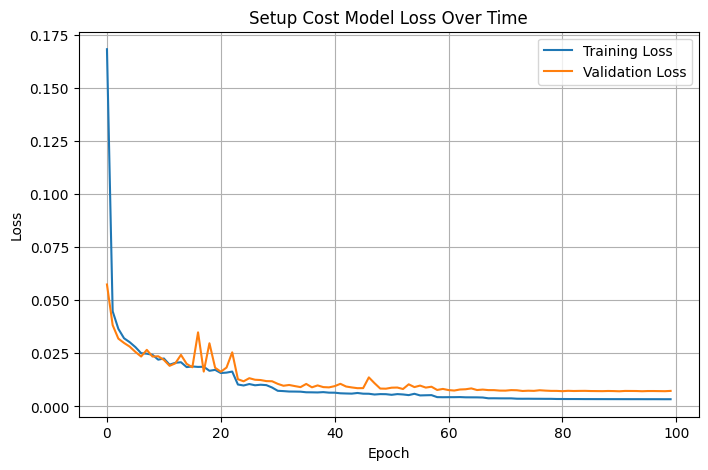

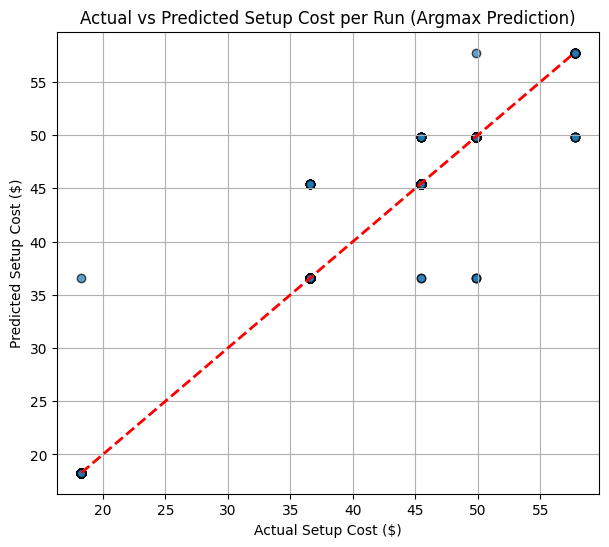

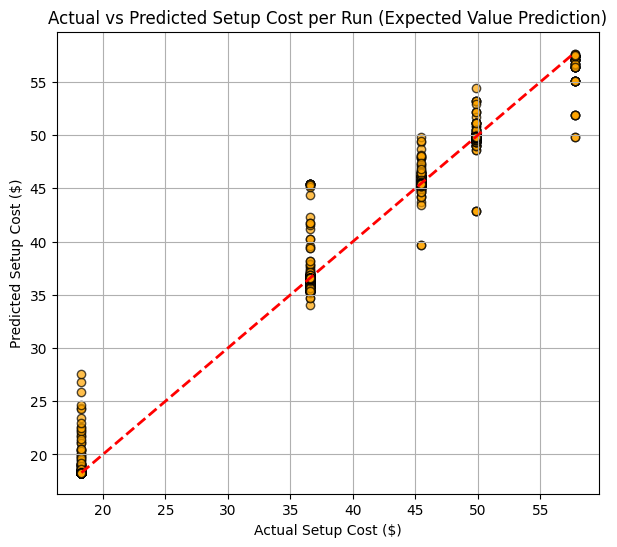

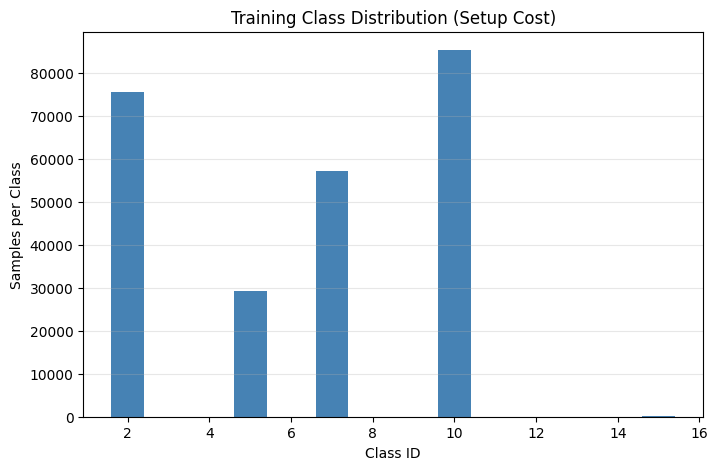

✅ Evaluation report saved to 'setup_cost_v1_2025-11-20_15-29-43.txt'

=== Summary Metrics ===
Accuracy: 99.94%
Mean Absolute Error (MAE): $0.01
Root Mean Square Error (RMSE): $0.22
Maximum Absolute Error: $18.28
Samples >$20 error: 0 / 61900
INFO:tensorflow:Assets written to: C:/models/setup_cost_price_model\assets


In [37]:
model_setup_cls, history_setup_cls, metrics_setup_cls = run_setup_cost_pipeline(
    X, y,
    target_col="setup_cost_per_run",
    min_class_samples=100,
    epochs=100,
    batch_size=256,
    output_prefix="setup_cost_v1"
)